In [90]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import tensorflow as tf
import tensorflow_recommenders as tfrs
import pandas as pd
import numpy as np
import json
import os

from tqdm.auto import tqdm
tqdm.pandas(leave=False)

# Training

## configuration

In [3]:
PROJECT             = "mlteam-ml-specialization-2021"
TRAIN_PATH          = "gs://mlteam-ml-specialization-2021-blackfriday/dataset/parsed/202104130952/train.csv"
TEST_PATH           = "gs://mlteam-ml-specialization-2021-blackfriday/dataset/parsed/202104130952/test.csv"
MODEL_NAME          = "000_hptuning_lr_ed_test"
BATCH_SIZE          = 30000 #1 epoch -> 3 steps
NUM_EPOCHS          = 10 # 1000
SCANN_NUM_NEIGHBORS = 10
#LEARNING_RATE       = 0.01
#EMBEDDING_DIM       = 128
USER_FEATURES       = ["Gender", "Age", "Occupation", "City_Category", "Stay_In_Current_City_Years", "Marital_Status"] 

In [2]:
%%writefile config.yaml
trainingInput:
  hyperparameters:
    goal: MINIMIZE
    hyperparameterMetricTag: epoch_total_loss
    maxTrials: 8
    maxParallelTrials: 8
    enableTrialEarlyStopping: False
    params:
    - parameterName: learning-rate
      type: DISCRETE
      discreteValues:
      - 0.01
      - 0.1
    - parameterName: embedding-dim
      type: DISCRETE
      discreteValues:
      - 16
      - 32
      - 64
      - 128

Overwriting config.yaml


In [3]:
MODEL_PATH = os.path.join("gs://mlteam-ml-specialization-2021-blackfriday/aiplatform_jobs", MODEL_NAME)
assert not tf.io.gfile.exists(MODEL_PATH), f"{MODEL_PATH} already exists"


os.environ["TRAIN_PATH"]          = str(TRAIN_PATH)
os.environ["TEST_PATH"]           = str(TEST_PATH)
os.environ["MODEL_NAME"]          = str(MODEL_NAME)
os.environ["MODEL_PATH"]          = str(MODEL_PATH)
os.environ["BATCH_SIZE"]          = str(BATCH_SIZE)
os.environ["NUM_EPOCHS"]          = str(NUM_EPOCHS)
os.environ["SCANN_NUM_NEIGHBORS"] = str(SCANN_NUM_NEIGHBORS)
#os.environ["LEARNING_RATE"]       = str(LEARNING_RATE)
#os.environ["EMBEDDING_DIM"]       = str(EMBEDDING_DIM)
os.environ["USER_FEATURES"]       = json.dumps(USER_FEATURES)

## launch

In [4]:
%%bash

# JOB_NAME: the name of your job running on AI Platform.
JOB_NAME=bf_${MODEL_NAME}_$(date +%Y%m%d_%H%M%S)

# REGION: select a region from https://cloud.google.com/ai-platform/training/docs/regions
# or use the default '`us-central1`'. The region is where the model will be deployed.
REGION=europe-west1
PYTHON_VERSION=3.7
RUNTIME_VERSION=2.4

current_dir="$(cd "$(dirname "${BASH_SOURCE[0]}")" >/dev/null 2>&1 && pwd)"
cd ${current_dir}"/../../.."

config_file="${current_dir}/config.yaml"

gcloud ai-platform jobs submit training "${JOB_NAME}" \
  --package-path trainer/ \
  --module-name trainer.task \
  --region ${REGION} \
  --python-version ${PYTHON_VERSION} \
  --runtime-version ${RUNTIME_VERSION} \
  --job-dir "${MODEL_PATH}" \
  --config "${config_file}" \
  -- \
  --train-path="${TRAIN_PATH}" \
  --job-dir="${MODEL_PATH}" \
  --num-epochs=${NUM_EPOCHS} \
  --batch-size=${BATCH_SIZE} \
  --scann-num-neighbors=${SCANN_NUM_NEIGHBORS} \
  --user-features="${USER_FEATURES}"

#  --learning-rate=${LEARNING_RATE} \
#  --embedding-dim=${EMBEDDING_DIM} \

gcloud ai-platform jobs describe ${JOB_NAME}

jobId: bf_000_hptuning_lr_ed_test_20210525_151105
state: QUEUED
createTime: '2021-05-25T15:11:08Z'
etag: ZM1JV44gdiM=
jobId: bf_000_hptuning_lr_ed_test_20210525_151105
state: PREPARING
trainingInput:
  args:
  - --train-path=gs://mlteam-ml-specialization-2021-blackfriday/dataset/parsed/202104130952/train.csv
  - --job-dir=gs://mlteam-ml-specialization-2021-blackfriday/aiplatform_jobs/000_hptuning_lr_ed_test
  - --num-epochs=10
  - --batch-size=30000
  - --scann-num-neighbors=10
  - --user-features=["Gender", "Age", "Occupation", "City_Category", "Stay_In_Current_City_Years",
    "Marital_Status"]
  hyperparameters:
    goal: MINIMIZE
    hyperparameterMetricTag: epoch_total_loss
    maxParallelTrials: 8
    maxTrials: 8
    params:
    - discreteValues:
      - 0.01
      - 0.1
      parameterName: learning-rate
      type: DISCRETE
    - discreteValues:
      - 16.0
      - 32.0
      - 64.0
      - 128.0
      parameterName: embedding-dim
      type: DISCRETE
  jobDir: gs://mlteam-ml

Job [bf_000_hptuning_lr_ed_test_20210525_151105] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe bf_000_hptuning_lr_ed_test_20210525_151105

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs bf_000_hptuning_lr_ed_test_20210525_151105

View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/bf_000_hptuning_lr_ed_test_20210525_151105?project=mlteam-ml-specialization-2021

View logs at:
https://console.cloud.google.com/logs?resource=ml_job%2Fjob_id%2Fbf_000_hptuning_lr_ed_test_20210525_151105&project=mlteam-ml-specialization-2021


In [5]:
!rm -rf config.yaml

In [45]:
metadata_path = os.path.join("gs://mlteam-ml-specialization-2021-blackfriday/aiplatform_jobs", MODEL_NAME, "metadata.json")

ml               = discovery.build('ml','v1')
projectId        = 'projects/{}'.format(PROJECT)
ai_platform_data = ml.projects().jobs().list(parent=projectId).execute()
jobs             = ai_platform_data["jobs"]
latest_job       = sorted([j for j in jobs if j['jobId'].startswith(f"bf_{MODEL_NAME}")], key=lambda x: x["jobId"])[-1]
if latest_job["trainingOutput"].get('isHyperparameterTuningJob',None) is not None:
    trials = latest_job["trainingOutput"]["trials"]
    json.dump(trials, tf.io.gfile.GFile(metadata_path, "w"))
else:
    metadata = [{
        'trialId'        : '1',
        'hyperparameters': {},
        'startTime'      : latest_job["startTime"],
        'endTime'        : latest_job["endTime"],
        'state'          : latest_job["state"],
    }]
    json.dump(metadata, tf.io.gfile.GFile(metadata_path, "w"))

# Evaluation

## ground truth

In [109]:
ALL_USER_FEATURES   = ["Gender", "Age", "Occupation", "City_Category", "Stay_In_Current_City_Years", "Marital_Status"] 

df=pd.read_csv(TEST_PATH).groupby(ALL_USER_FEATURES)["Product_ID"].apply(list).reset_index()

## baseline

In [110]:
class BlackFridayBaseline:
    def __init__(self, trainset_location, user_features_list, build_inplace=False):
        self.trainset_location, self.user_features_list = trainset_location, user_features_list
        if build_inplace:
            self.build()
        
    def build(self):
        self.df = pd.read_csv(self.trainset_location).groupby(
            self.user_features_list+["Product_ID"])["User_ID"].count().reset_index().rename(
            columns={"User_ID":"count_product"})
        
    def predict(self, user_features, n_products):
        mask = None
        for k,v in user_features.items():
            if mask is None:
                mask = self.df[k]==v
            else:
                mask = mask&(self.df[k]==v)
        return self.df[mask].sort_values(self.user_features_list+["count_product"])["Product_ID"].values[:n_products]
        

In [111]:
baseline = BlackFridayBaseline(TRAIN_PATH, ALL_USER_FEATURES, True)
df["baseline"]=df[ALL_USER_FEATURES].progress_apply(lambda x: baseline.predict(x, SCANN_NUM_NEIGHBORS), axis=1)

  0%|          | 0/2430 [00:00<?, ?it/s]

## model(s)

In [112]:
class PredictionModel:
    def __init__(self, model_path, build_inplace=False):
        self.model_path=model_path
        if build_inplace:
            self.build()
    
    def build(self):
        self.model=tf.keras.models.load_model(self.model_path)
        
    def predict_batch(self, model_input):
        scores, products = self.model({k:tf.constant(v) for k,v in model_input.items()})
        return products.numpy()
    
    def predict_single(self, model_input):
        scores, products = self.model({k:tf.constant([v]) for k,v in model_input.items()})
        return products.numpy()
    

def evaluate_model(data_df, model, baseline_precision, title="", figsize=(20,10)):
    k_min = SCANN_NUM_NEIGHBORS
    df=data_df.copy()
    df["predictions"]=df[USER_FEATURES].progress_apply(lambda x: model.predict_single({k:str(v) for k,v in x.items()})[0].astype(str), axis=1)
    df_orig=df
    df=df_orig[df_orig["Product_ID"].apply(len) >= k_min]
    df_metrics = pd.DataFrame(index=df.index)
    df_metrics["baseline_precision"]=baseline_precision
    df_metrics["predictions_precision"]=df[["Product_ID","predictions"]].progress_apply(lambda x: np.intersect1d(x["Product_ID"],x["predictions"]).shape[0]/k_min,axis=1)
    pd.DataFrame([
        df_metrics["baseline_precision"].apply(lambda x: round(x,2)).value_counts(),
        df_metrics["predictions_precision"].apply(lambda x: round(x,2)).value_counts()
    ]).transpose().fillna(0).plot.bar(figsize=figsize, title=title)
    return df_metrics[["baseline_precision","predictions_precision"]].mean()    
    

  0%|          | 0/2407 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2430 [00:00<?, ?it/s]

  0%|          | 0/2407 [00:00<?, ?it/s]

  0%|          | 0/2430 [00:00<?, ?it/s]

  0%|          | 0/2407 [00:00<?, ?it/s]

  0%|          | 0/2430 [00:00<?, ?it/s]

  0%|          | 0/2407 [00:00<?, ?it/s]

  0%|          | 0/2430 [00:00<?, ?it/s]

  0%|          | 0/2407 [00:00<?, ?it/s]

  0%|          | 0/2430 [00:00<?, ?it/s]

  0%|          | 0/2407 [00:00<?, ?it/s]

  0%|          | 0/2430 [00:00<?, ?it/s]

  0%|          | 0/2407 [00:00<?, ?it/s]

  0%|          | 0/2430 [00:00<?, ?it/s]

  0%|          | 0/2407 [00:00<?, ?it/s]

  0%|          | 0/2430 [00:00<?, ?it/s]

  0%|          | 0/2407 [00:00<?, ?it/s]

,precision,hyperparameters
baseline,0.400166,NaN
trial_4,0.073702,"{'embedding-dim': '16', 'learning-rate': '0.01'}"
trial_7,0.050602,"{'embedding-dim': '128', 'learning-rate': '0.1'}"
trial_2,0.04005,"{'embedding-dim': '32', 'learning-rate': '0.01'}"
trial_8,0.032696,"{'embedding-dim': '128', 'learning-rate': '0.01'}"
trial_1,0.03253,"{'embedding-dim': '64', 'learning-rate': '0.1'}"
trial_5,0.032364,"{'embedding-dim': '64', 'learning-rate': '0.01'}"
trial_6,0.024263,"{'embedding-dim': '16', 'learning-rate': '0.1'}"
trial_3,0.016618,"{'embedding-dim': '32', 'learning-rate': '0.1'}"


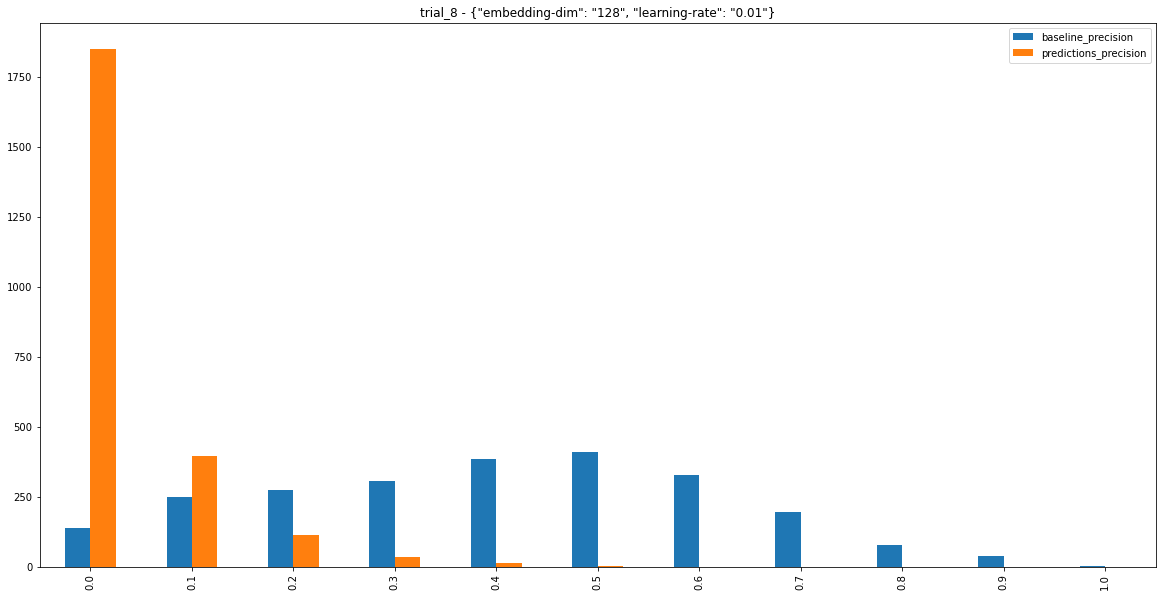

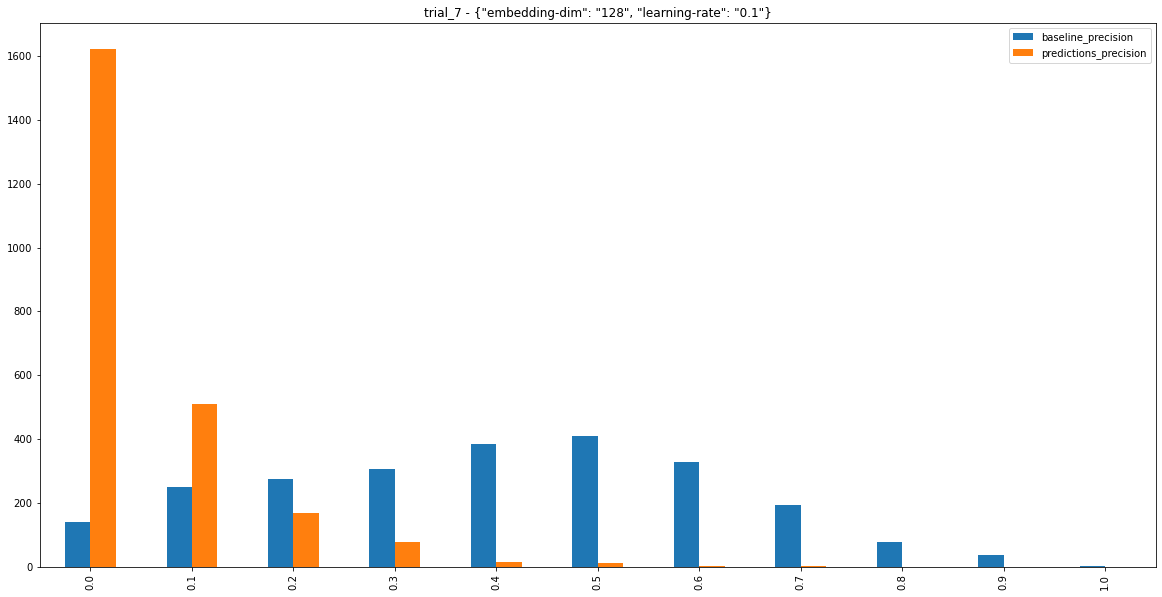

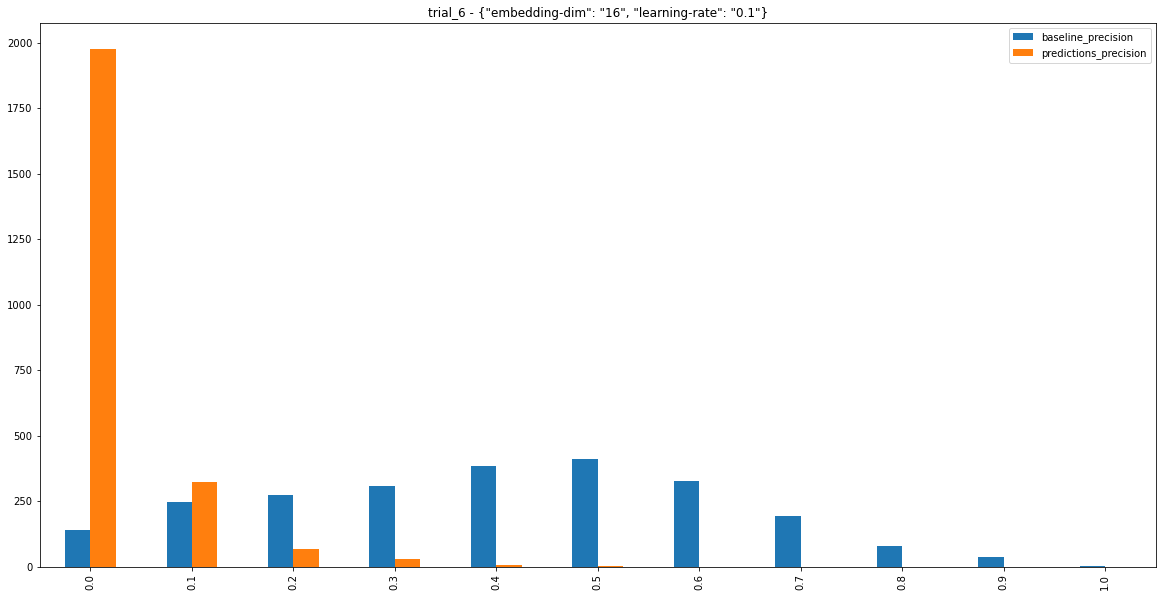

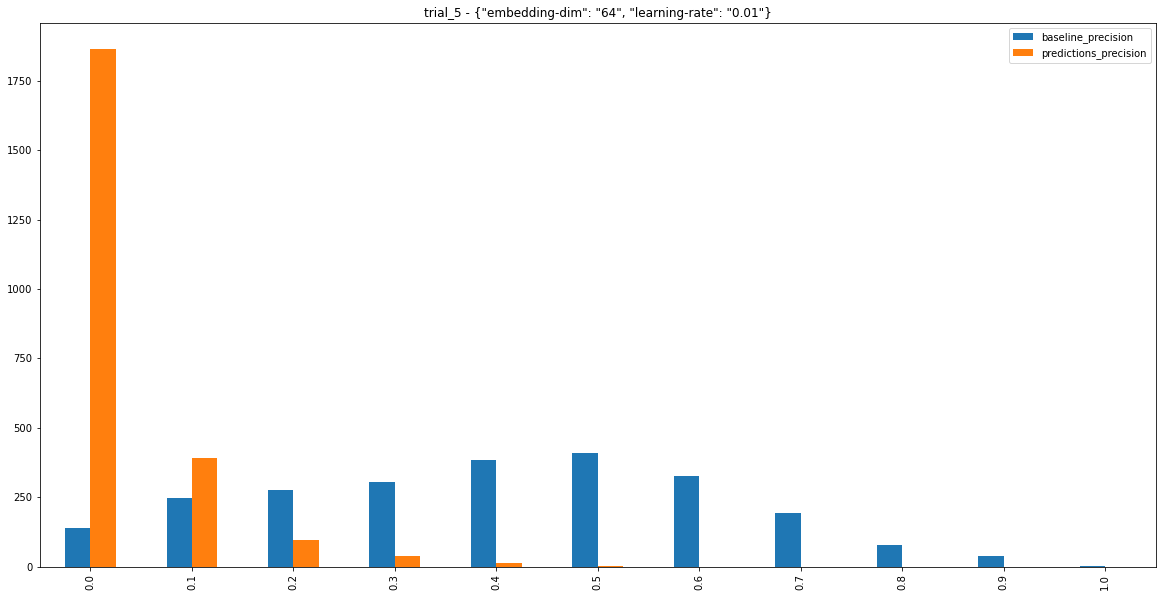

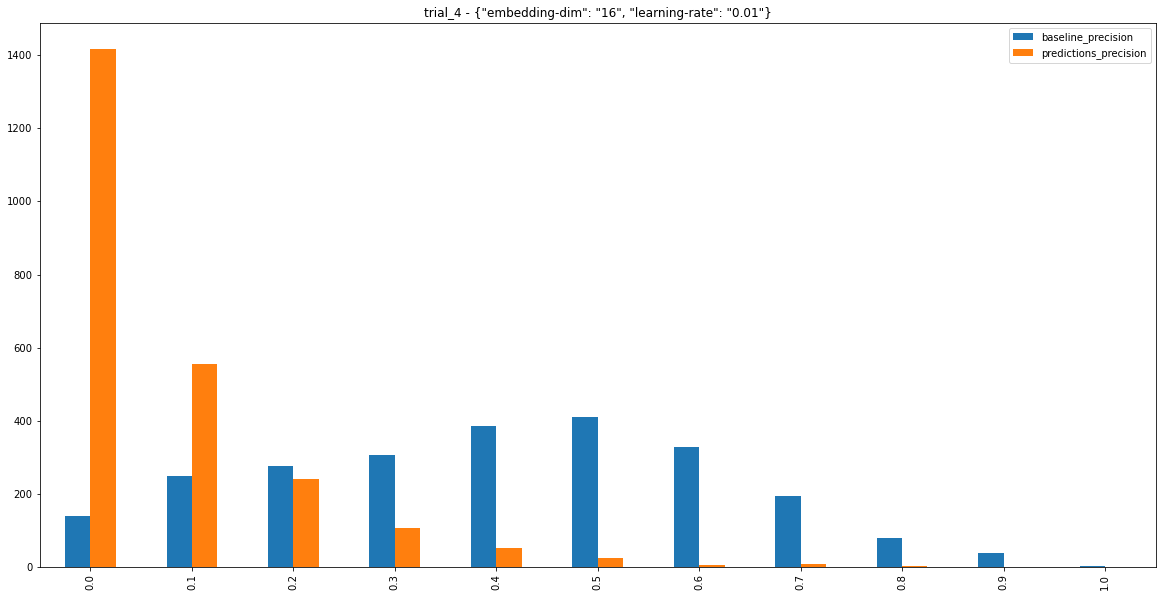

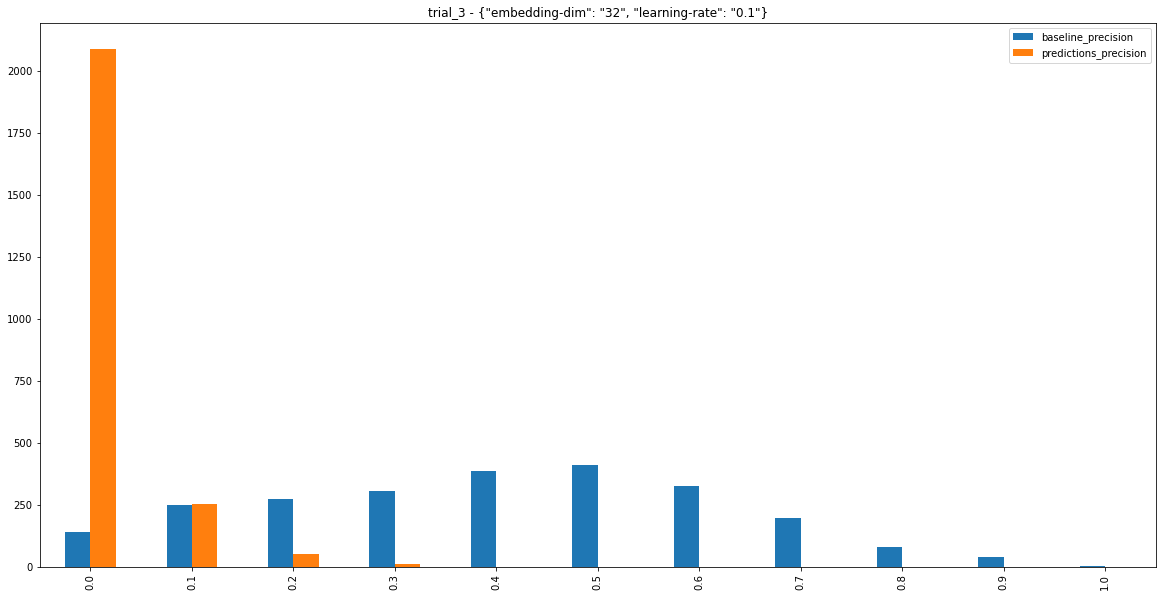

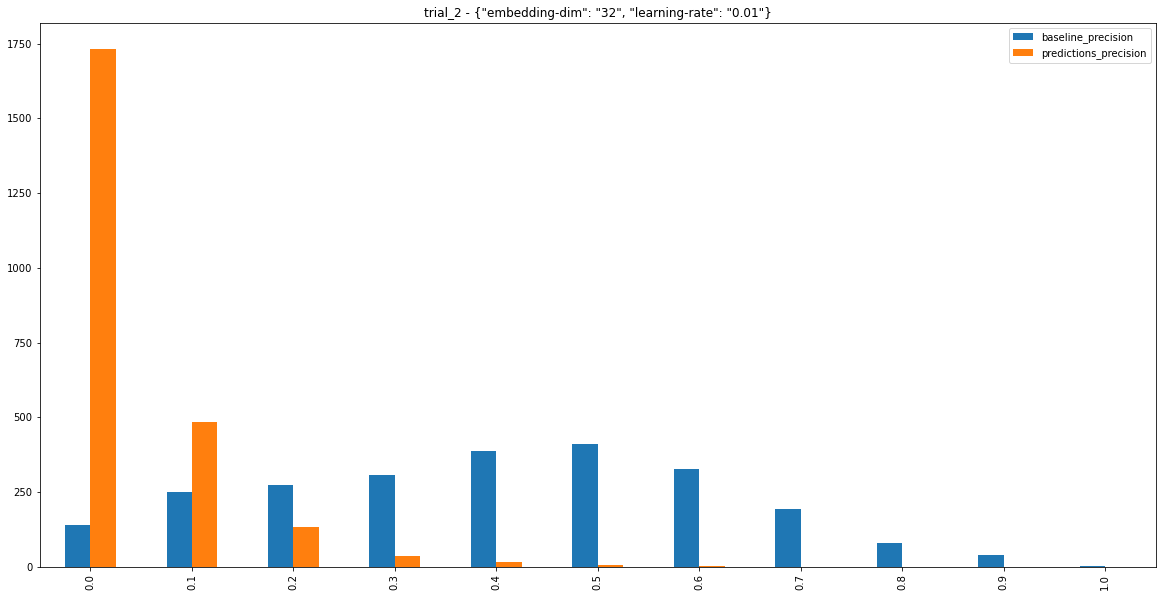

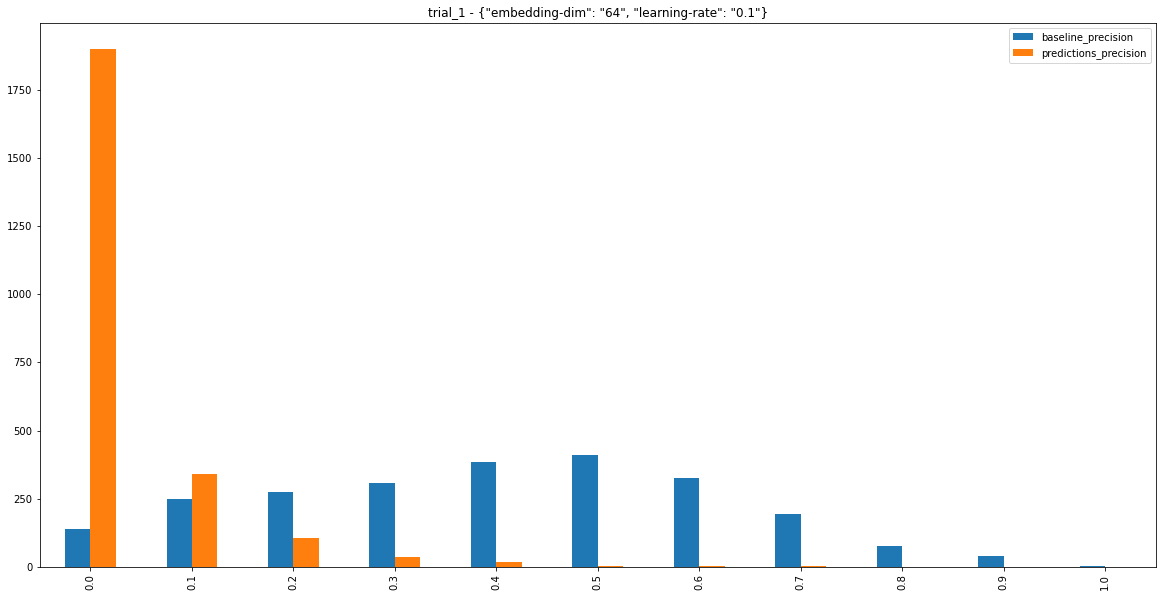

In [113]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
metadata_path = os.path.join("gs://mlteam-ml-specialization-2021-blackfriday/aiplatform_jobs", MODEL_NAME, "metadata.json")
metadata = json.load(tf.io.gfile.GFile(metadata_path, "r"))
results = {}
baseline_precision=df[
    df["Product_ID"].apply(len) >= SCANN_NUM_NEIGHBORS
][
    ["Product_ID","baseline"]
].progress_apply(
    lambda x: np.intersect1d(x["Product_ID"],x["baseline"]).shape[0]/SCANN_NUM_NEIGHBORS,
    axis=1
)
results["baseline"] = {"precision":baseline_precision.mean()}
for j in tqdm(metadata):
    model = PredictionModel(os.path.join("gs://mlteam-ml-specialization-2021-blackfriday/aiplatform_jobs", MODEL_NAME, j['trialId'], 'Scann'), True)
    hps = json.dumps(j["hyperparameters"])
    res = evaluate_model(df, model, baseline_precision, title=f"trial_{j['trialId']} - {hps}")
    #results["baseline"]={"precision":res["baseline_precision"]}
    results[f"trial_{j['trialId']}"] = {"precision":res["predictions_precision"], "hyperparameters": j["hyperparameters"]}
    
pd.DataFrame(results).T.sort_values(by="precision", ascending=False)